# TODO
- create `torch` modules ready to place at the top of the transformer
    - requires alignment with some interface of the autoencoder
- make the learning rate scheduler not vanish the lr rate
- add the schedulers of the loss terms to put attention to different terms throught training

In [85]:
import os

os.chdir("../src")

from utils import data_utils

import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc

pd.set_option("display.max_columns", None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import Tensor
from typing import List, Tuple, Optional
from pandas import DataFrame
from argparse import Namespace
from sklearn.model_selection import train_test_split
import scanpy as sc
from utils import dev_notebooks_utils as dev
from utils.paths import LOGS_PATH
import h5py
import pytorch_lightning as pl
from torch.optim.lr_scheduler import LinearLR, ExponentialLR, ChainedScheduler
from torch.utils.data import TensorDataset, DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# `from sklearn.preprocessing import LabelEncoder


# # Note: only preprosessing, which keeps 0 as 0 is allowed if we want to 0 mean no expression
# def prepare_data(
#     val_frac: float,
#     divide_by_nonzero_median: bool,
#     df_columns: List[str],
#     random_state: int = 0,
#     return_raw: bool = False,
# ) -> Tuple[Tensor, Tensor, Tensor, Tensor, Tensor, Tensor, LabelEncoder]:
#     data = data_utils.load_anndata(mode="train", plus_iid_holdout=True, normalize=False)
#     sc.pp.log1p(data)
#     data = data[data.obs["is_train"].apply(lambda x: x in ["train", "iid_holdout"])]

#     tensor_data = torch.tensor(data.X.todense(), dtype=torch.float32, device=device)
#     raw = data.layers["counts"]
#     df = pd.DataFrame(data.obs[df_columns])
#     del data

#     if divide_by_nonzero_median:
#         nonzero_median = tensor_data[tensor_data > 0].median(dim=0, keepdim=True).values
#         tensor_data = tensor_data / nonzero_median
#         del nonzero_median

#     train_tensor_data, val_tensor_data, train_df, val_df, train_raw, val_raw = (
#         train_test_split(
#             tensor_data, df, raw, test_size=val_frac, random_state=random_state
#         )
#     )

#     if return_raw:
#         return train_tensor_data, val_tensor_data, train_df, val_df, train_raw, val_raw

#     return train_tensor_data, val_tensor_data, train_df, val_df`

In [4]:
(train_tensor_data, val_tensor_data), (train_df, val_df), (train_raw, val_raw) = (
    dev.prepare_data_naive_mixing_version(
        val_frac=0.1,
        divide_by_nonzero_median=True,
        df_columns=["cell_type", "batch", "Site", "DonorNumber"],
        return_raw=True,
    )
)

/home/prz/bioml/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Subsampling anndata with fraction 1.0...


/home/prz/bioml/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:405: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Input PCA UMAP reference

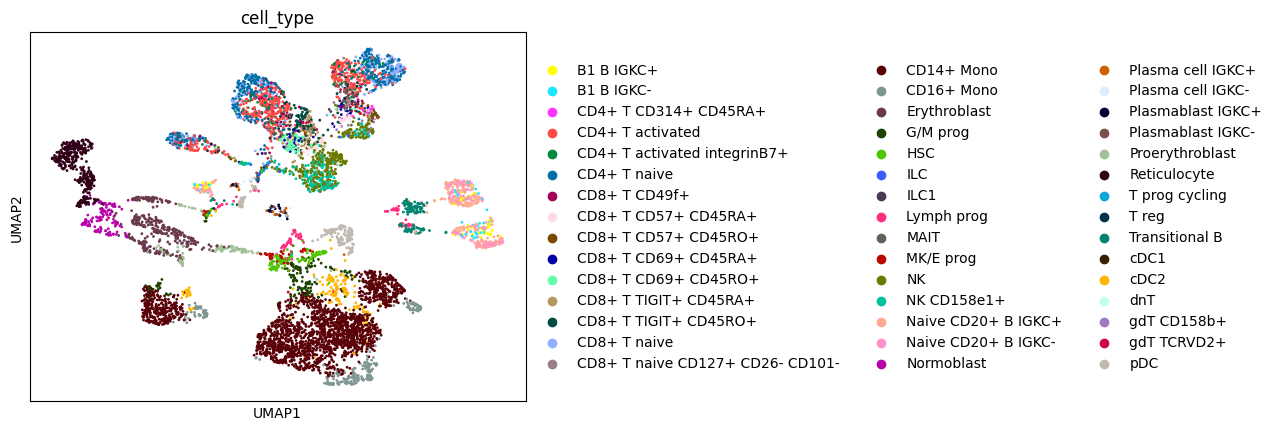

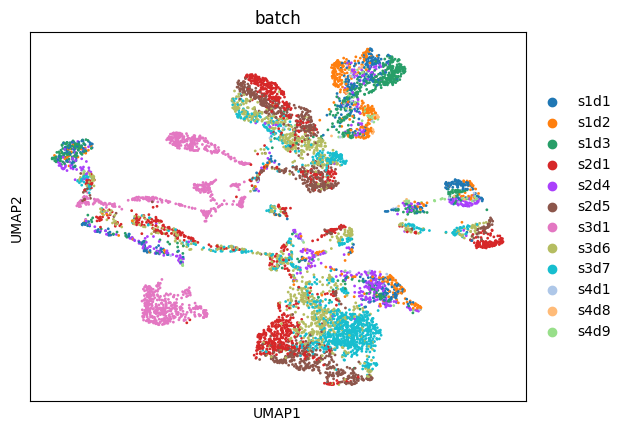

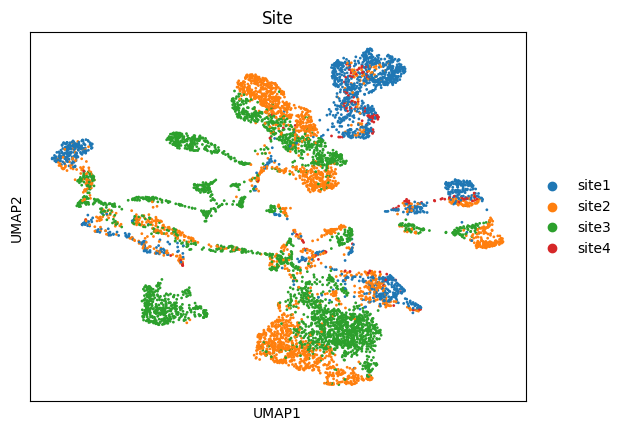

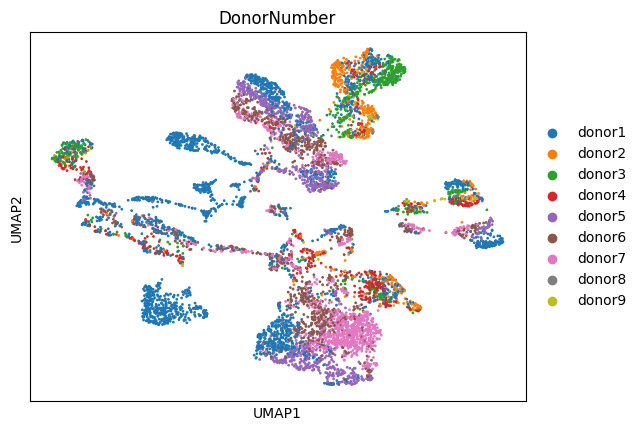

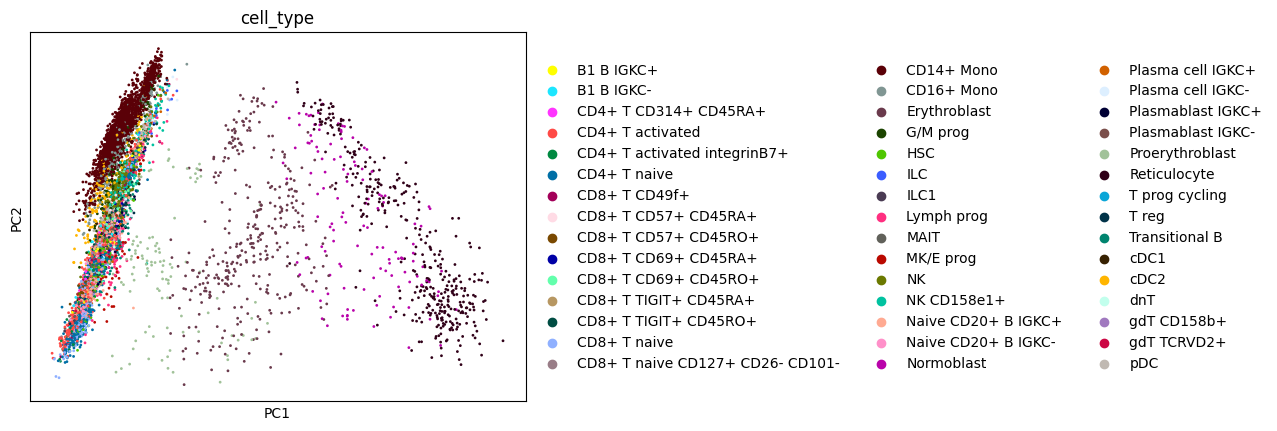

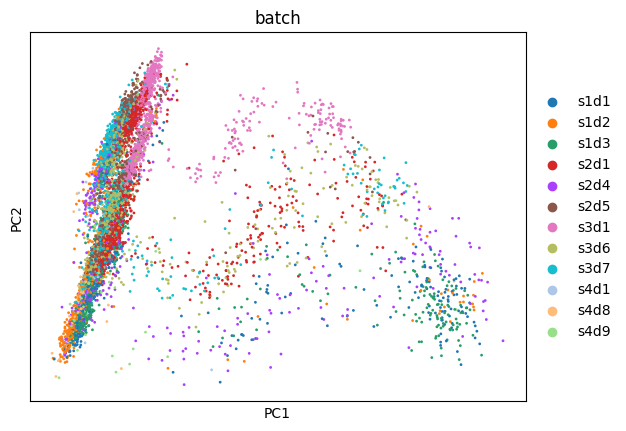

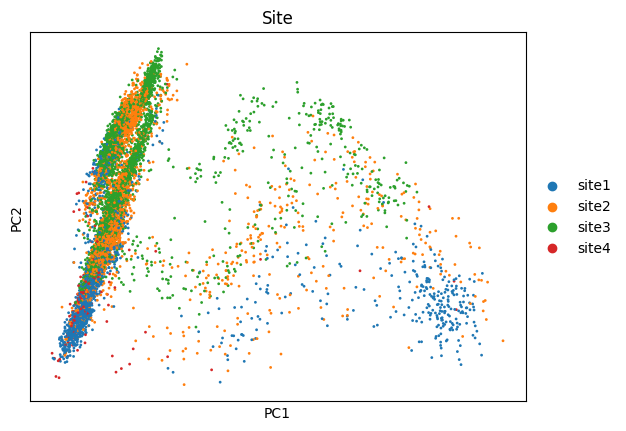

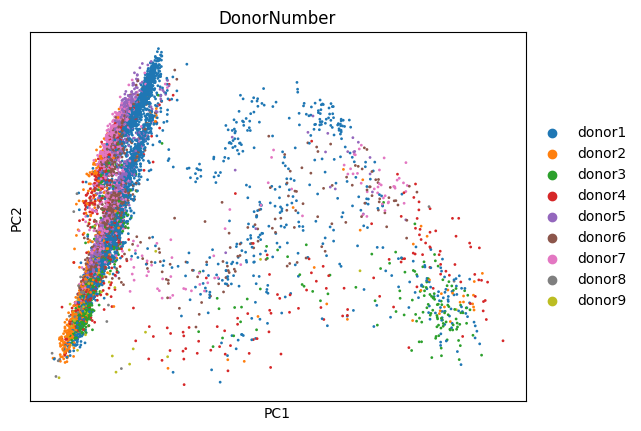

In [5]:
dev.draw_umaps_pca(val_tensor_data.numpy(), val_df)

#### Checking PCA after pearson residuals normalisation on the validation data

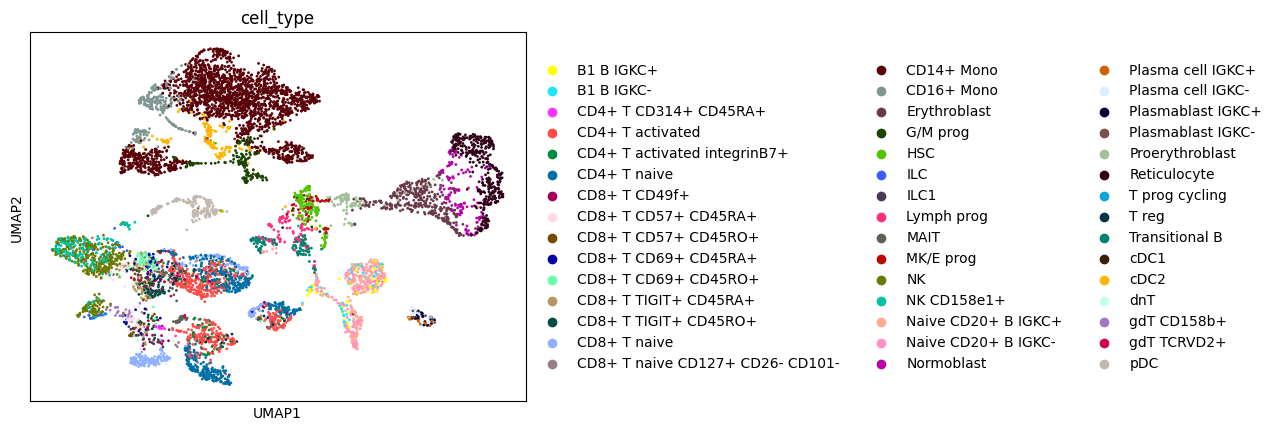

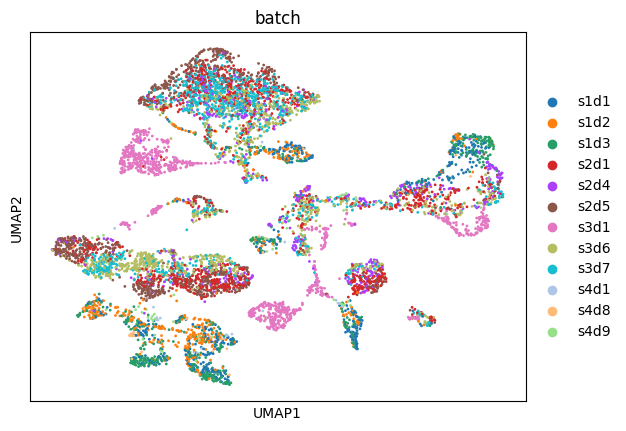

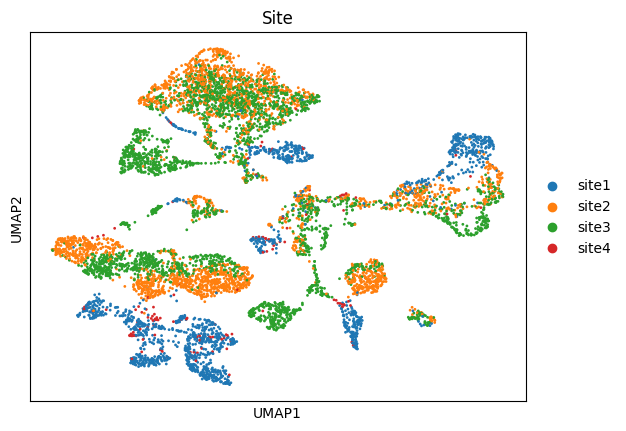

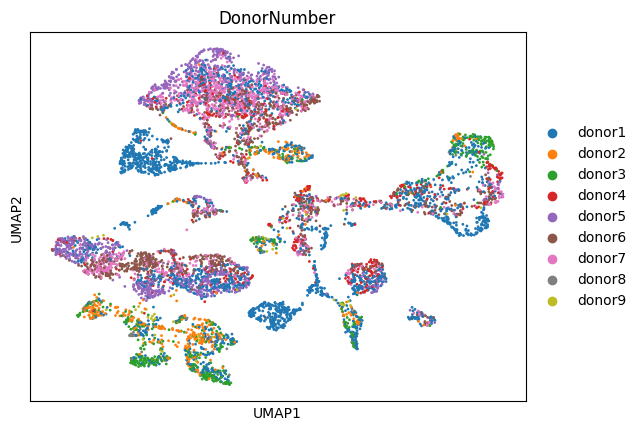

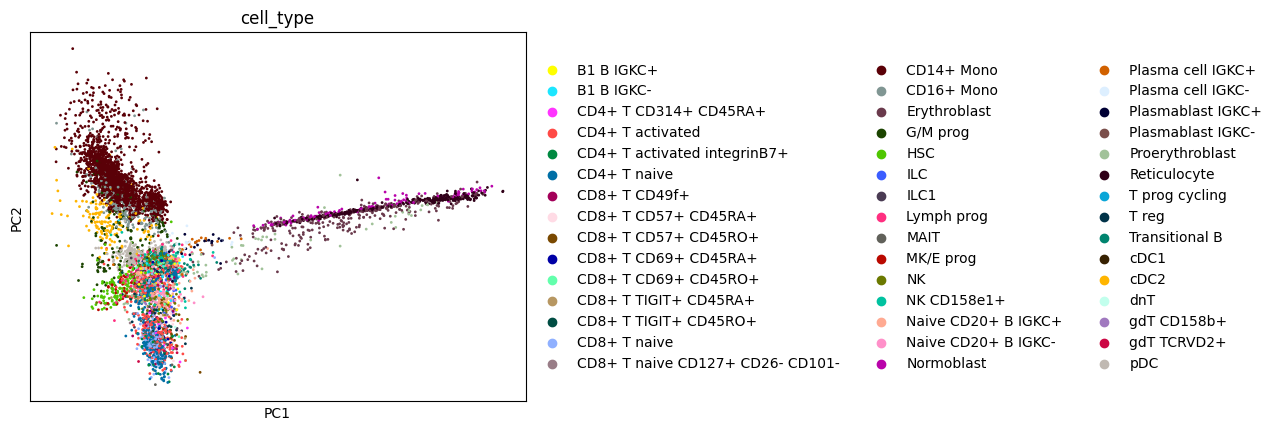

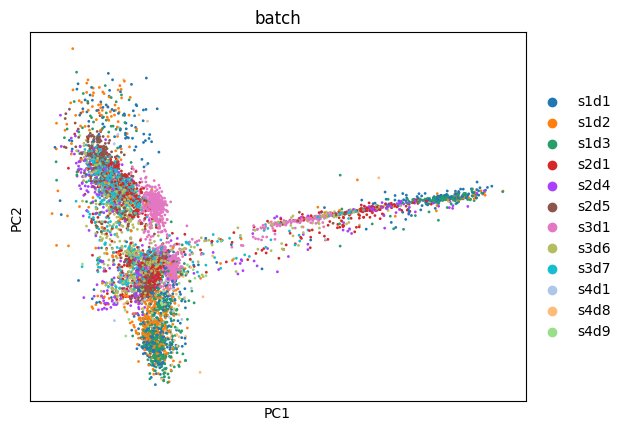

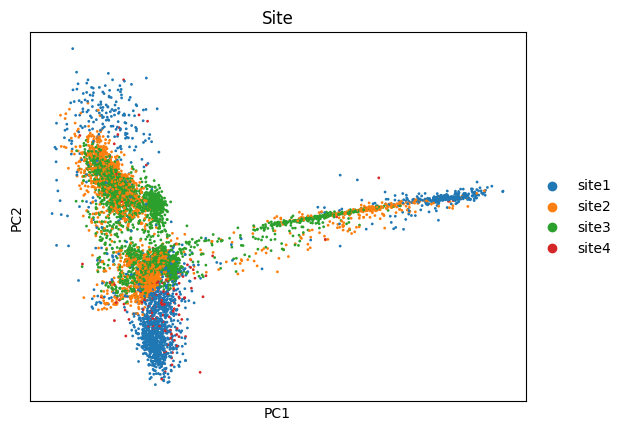

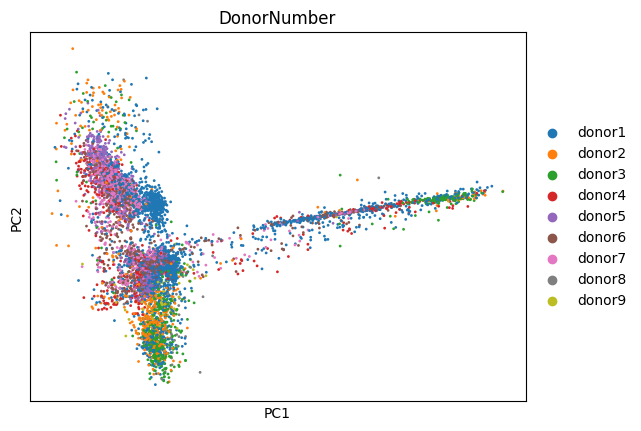

In [6]:
ad_tmp = ad.AnnData(X=val_raw.numpy(), obs=val_df)
sc.experimental.pp.normalize_pearson_residuals(ad_tmp)
dev.draw_umaps_pca(ad_tmp.X, val_df)
del ad_tmp

### Model components

In [26]:
class Encoder(nn.Module):
    def __init__(
        self,
        latent_dims: int,
        hidden_dims: int,
        input_dims: int,
        dropout: float,
        batch_norm: bool,
    ):  # dropout, z_dropout define the dropout rates of the encoder/latent space
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(p=dropout) if dropout > 0 else nn.Identity(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(p=dropout) if dropout > 0 else nn.Identity(),
            nn.Linear(hidden_dims, latent_dims),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return encoded


class Decoder(nn.Module):
    def __init__(
        self,
        latent_dims: int,
        hidden_dims: int,
        input_dims: int,
        dropout: float,
        batch_norm: bool,
    ):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(p=dropout) if dropout > 0 else nn.Identity(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(p=dropout) if dropout > 0 else nn.Identity(),
            nn.Linear(hidden_dims, input_dims),
        )

    def forward(self, z):
        decoded = self.decoder(z)
        return decoded

## AE

In [33]:
class AE(pl.LightningModule):
    def __init__(self, cfg):
        super(AE, self).__init__()
        self.encoder = Encoder(
            cfg.model.latent_dim,
            cfg.model.embedding_dim,
            cfg.model.num_genes,
            cfg.model.encoder.dropout,
            cfg.model.encoder.batch_norm,
        )
        self.decoder = Decoder(
            cfg.model.latent_dim,
            cfg.model.embedding_dim,
            cfg.model.num_genes,
            cfg.model.decoder.dropout,
            cfg.model.decoder.batch_norm,
        )
        self.cfg = cfg

    def encode(self, x):
        encoded = self.encoder(x)
        return encoded

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def training_step(self, batch, batch_idx):
        x = batch[0]
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[0]
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log(
            "val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def configure_optimizers(self):
        encoder_optimizer_params = {
            "params": self.encoder.parameters(),
            **vars(self.cfg.training.optimizer.encoder),
        }
        decoder_optimizer_params = {
            "params": self.decoder.parameters(),
            **vars(self.cfg.training.optimizer.decoder),
        }
        optimizer = torch.optim.Adam(
            [encoder_optimizer_params, decoder_optimizer_params]
        )

        first_phase_scheduler = LinearLR(
            optimizer,
            start_factor=0.1,
            end_factor=1.0,
            total_iters=self.cfg.training.optimizer.first_phase_iters,
        )
        second_phase_scheduler = ExponentialLR(
            optimizer, gamma=self.cfg.training.optimizer.second_phase_gamma
        )
        scheduler = ChainedScheduler([first_phase_scheduler, second_phase_scheduler])

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "frequency": self.cfg.training.optimizer.scheduler_frequency,
            },
        }

In [40]:
# be flexible about the configuration
cfg_dict = {
    "model": {
        "model_name": "ae_1.0",
        "num_genes": 14087,
        "embedding_dim": 50,
        "latent_dim": 20,
        "encoder": {
            "batch_norm": True,
            "dropout": 0.1,
        },
        "decoder": {
            "batch_norm": True,
            "dropout": 0.1,
        },
    },
    "training": {
        "batch_size": 64,
        "optimizer": {
            "encoder": {
                "type": "AdamW",
                "kwargs": {
                    "lr": 1e-3,
                    "weight_decay": 1e-3,
                    "momentum": 0.9,
                    "nesterov": True,
                    "amsgrad": True,
                },
            },
            "decoder": {
                "type": "AdamW",
                "kwargs": {
                    "lr": 1e-3,
                    "weight_decay": 1e-3,
                    "momentum": 0.9,
                    "nesterov": True,
                    "amsgrad": True,
                },
            },
            "second_phase_gamma": 0.9,
            "scheduler_frequency": 1,
            "first_phase_iters": 5,
        },
        "n_epochs": 1,
    },
}

ae_cfg = dev.dict_to_namespace(cfg_dict)

In [35]:
train_tensor_dataset = TensorDataset(train_tensor_data)
train_loader = DataLoader(
    train_tensor_dataset, batch_size=ae_cfg.training.batch_size, shuffle=True
)
val_tensor_dataset = TensorDataset(val_tensor_data)
val_loader = DataLoader(
    val_tensor_dataset, batch_size=ae_cfg.training.batch_size, shuffle=False
)

In [36]:
# run tensorboard
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 71729), started 0:32:35 ago. (Use '!kill 71729' to kill it.)

In [37]:
trainer = pl.Trainer(
    max_epochs=ae_cfg.training.n_epochs,
    logger=pl.loggers.TensorBoardLogger(LOGS_PATH, name=ae_cfg.model.model_name),
)
model = AE(ae_cfg)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [38]:
trainer.fit(model, train_loader, val_loader)


  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 708 K  | train
1 | decoder | Decoder | 722 K  | train
--------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.722     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/prz/bioml/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/prz/bioml/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/home/prz/bioml/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Embeddings UMAP - AE

In [14]:
embeddings_path = dev.get_data_embeddings(
    tensor_dataset=val_tensor_dataset, model=model
)

In [15]:
with h5py.File(embeddings_path, "r") as h5f:
    embeddings = h5f["embeddings"][:]

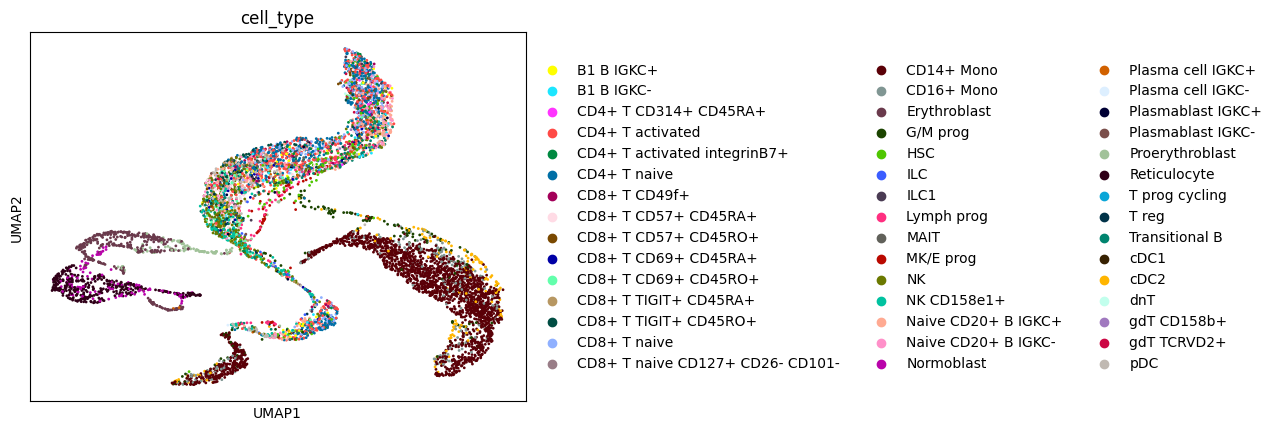

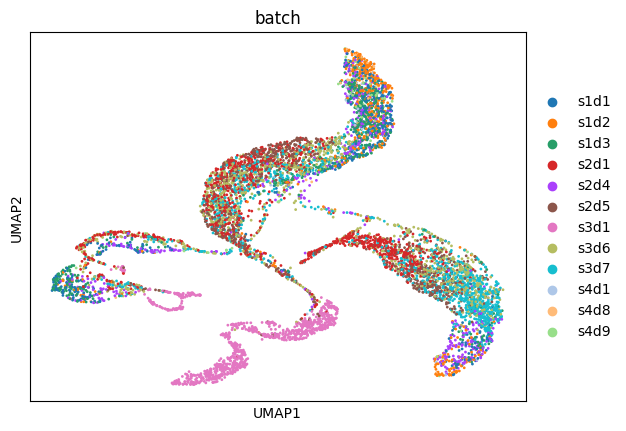

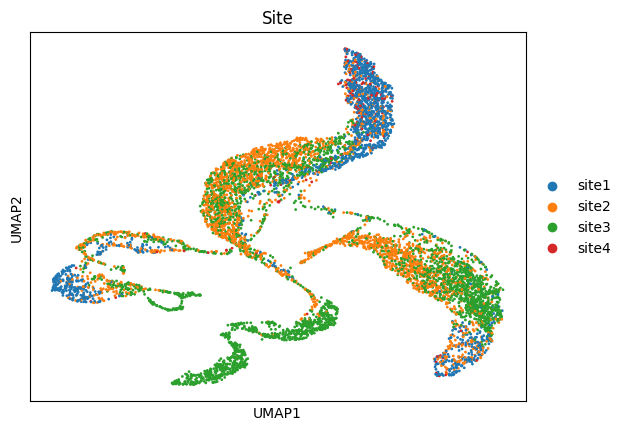

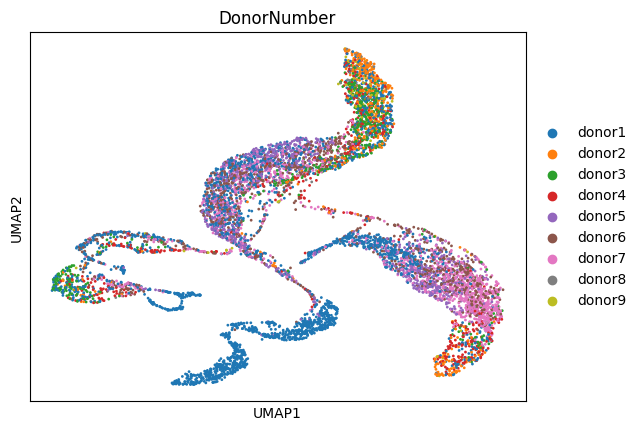

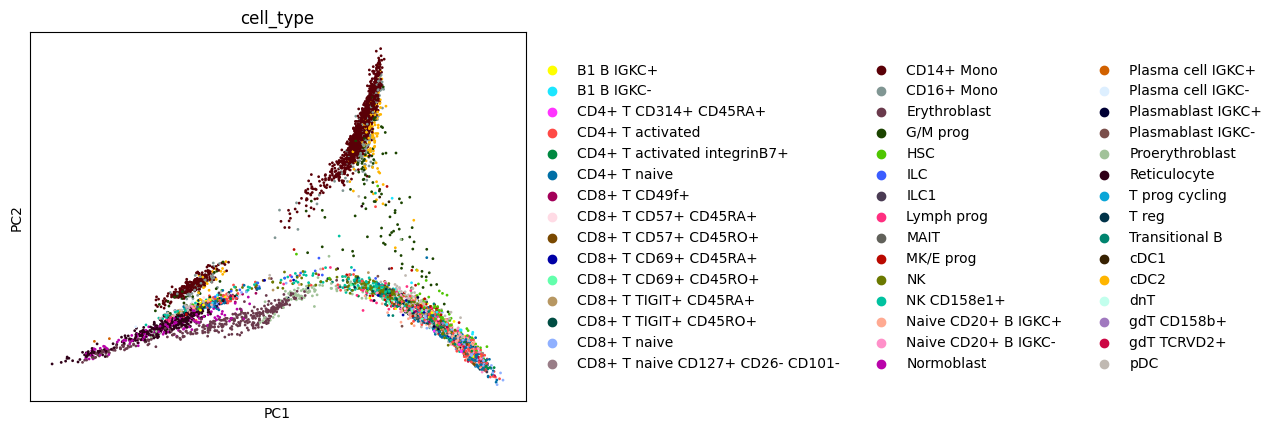

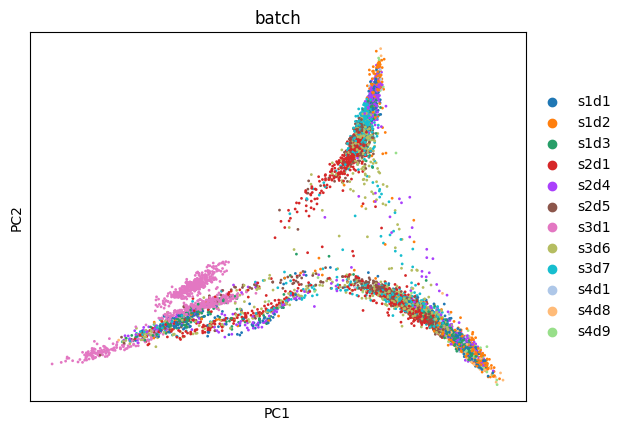

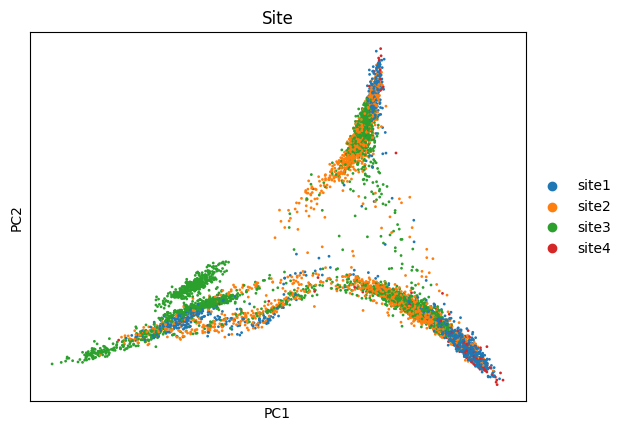

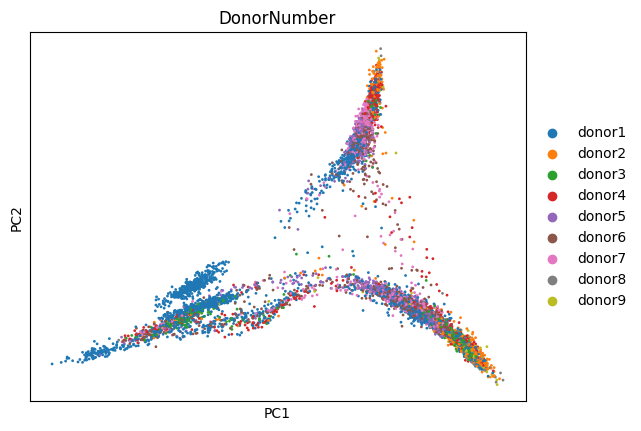

In [20]:
dev.draw_umaps_pca(embeddings, val_df, n_comps=16)

## RAE
[From Variational to Deterministic Autoencoders](https://arxiv.org/abs/1903.12436)

### Components
#### Decoder regularisation
- implicit: dropout, batchnorm, noise during training
- explicit: higher weight decay, [instance noise](https://arxiv.org/pdf/1610.04490) in AE setup - just adding noise to the loss, does it even make any sense here? - i do not think so, weight clipping, gradient wrt latent penalty, spectral normalisation

In [96]:
from torch.nn.utils import spectral_norm


class RAE(AE):
    def __init__(self, cfg):
        super(RAE, self).__init__(cfg)
        if cfg.model.decoder.spectral_norm.is_applied:
            self._wrap_decoder_weights_with_spectral_norm()
        if cfg.model.decoder.weight_clipping.is_applied:
            self._clip_decoder_weights()

        if cfg.training.loss.latent_regularization.is_applied:
            if cfg.training.loss.latent_regularization.type == "l2":
                self._latent_reg_loss = lambda z: z.pow(2).sum()
            elif cfg.training.loss.latent_regularization.type == "huber":
                self._latent_reg_loss = lambda z: F.huber_loss(
                    z, torch.zeros_like(z), delta=1.0
                )

    def _wrap_decoder_weights_with_spectral_norm(self):
        r"""
        Apply spectral normalization to the decoder layers
        """
        for module in self.decoder.modules():
            if isinstance(
                module, nn.Linear
            ):  # note that it is applied to the linear layers only
                spectral_norm(
                    module,
                    n_power_iterations=self.cfg.model.decoder.spectral_norm.n_power_iterations,
                )  # This is implemented via a hook that calculates spectral norm and rescales weight before every forward() call.

    def _register_decoder_weight_clipping_hook(self):
        r"""
        Register a hook to clip the weights of the decoder
        """

        def _clip_weights_hook(module: nn.Module, input: Tensor) -> None:
            if module.training:
                if hasattr(module, "weight"):
                    with torch.no_grad():
                        module.weight.data._clamp(
                            self.cfg.model.decoder.weight_clipping.min,
                            self.cfg.model.decoder.weight_clipping.max,
                        )

        for module in self.decoder.modules():
            if isinstance(module, nn.Linear):
                module._register_forward_post_hook(_clip_weights_hook)

    # def _calc_decoder_output_gradient_wrt_input_sum_of_squares_loss_term(
    #     self, inputs: Tensor, outputs: Tensor
    # ) -> Tensor:
    #     r"""
    #     Compute the sum of squares of the gradient of the decoder output with respect to its latent input.
    #     """
    #     outputs_sum = outputs.sum()
    #     grads = torch.autograd.grad(
    #         outputs=outputs_sum,
    #         inputs=inputs,
    #         grad_outputs=torch.ones_like(outputs_sum),
    #     )[0]
    #     return grads.pow(2).sum()

    def _calc_latent_regularization_loss_term(self, z: Tensor) -> Tensor:
        r"""
        Compute the latent regularization loss
        """
        # return z.pow(2).sum()  # not putting 0.5 here as it is a constant factor
        return self._latent_reg_loss(z)

    def _calc_recon_loss_term(self, x_hat: Tensor, x: Tensor) -> Tensor:
        r"""
        Compute the reconstruction loss
        """
        return F.mse_loss(x_hat, x)

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

    def training_step(self, batch, batch_idx):
        x = batch[0]
        x_hat, z = self(x)
        recon_loss = self._calc_recon_loss_term(x_hat, x)
        latent_regularization_loss = self._calc_latent_regularization_loss_term(z)
        # decoder_regularization_loss = (
        #     self._calc_decoder_output_gradient_wrt_input_sum_of_squares_loss_term(
        #         z, x_hat
        #     )
        # )
        loss = (
            self.cfg.training.loss.loss_weights.recon * recon_loss
            + self.cfg.training.loss.loss_weights.latent_regularization
            * latent_regularization_loss
            # + self.cfg.training.loss.loss_weights.decoder_regularization
            # * decoder_regularization_loss
        )
        self.log_dict(
            {
                "train_recon_loss": recon_loss,
                "train_latent_regularization_loss": latent_regularization_loss,
                # "train_decoder_regularization_loss": decoder_regularization_loss,
            },
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[0]
        x_hat, z = self(x)
        recon_loss = self._calc_recon_loss_term(x_hat, x)
        latent_regularization_loss = self._calc_latent_regularization_loss_term(z)
        # decoder_regularization_loss = (
        #     self._calc_decoder_output_gradient_wrt_input_sum_of_squares_loss_term(
        #         z, x_hat
        #     )
        # )
        loss = (
            self.cfg.training.loss.loss_weights.recon * recon_loss
            + self.cfg.training.loss.loss_weights.latent_regularization
            * latent_regularization_loss
            # + self.cfg.training.loss.loss_weights.decoder_regularization
            # * decoder_regularization_loss
        )
        self.log_dict(
            {
                "val_recon_loss": recon_loss,
                "val_latent_regularization_loss": latent_regularization_loss,
                # "val_decoder_regularization_loss": decoder_regularization_loss,
            },
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        return loss

In [108]:
# be flexible about the configuration
cfg_dict = {
    "model": {
        "model_name": "rae_1.0",
        "num_genes": 14087,
        "embedding_dim": 50,
        "latent_dim": 20,
        "encoder": {
            "batch_norm": True,
            "dropout": 0.0,
        },
        "decoder": {
            "batch_norm": True,
            "dropout": 0.0,
            "spectral_norm": {
                "is_applied": True,
                "n_power_iterations": 1,
            },
            "weight_clipping": {
                "is_applied": False,
                "min": -1,
                "max": 1,
            },
        },
    },
    "training": {
        "batch_size": 64,
        "optimizer": {
            "encoder": {
                "type": "AdamW",
                "kwargs": {
                    "lr": 1e-3,
                    "weight_decay": 1e-4,
                    "momentum": 0.9,
                    "nesterov": True,
                    "amsgrad": True,
                },
            },
            "decoder": {
                "type": "AdamW",
                "kwargs": {
                    "lr": 1e-3,
                    "weight_decay": 1e-3,
                    "momentum": 0.9,
                    "nesterov": True,
                    "amsgrad": True,
                },
            },
            "second_phase_gamma": 0.9,
            "scheduler_frequency": 1,
            "first_phase_iters": 5,
        },
        "losses": {
            "recon": {"type": "mse", "weight": 1.0},
            "latent_regularization": {
                "is_applied": True,
                "type": "huber",
                "weight": 0.000001,
            },
            "decoder_regularization": {"is_applied": False, "weight": 1.0},
        },
        "n_epochs": 10,
    },
}

rae_cfg = dev.dict_to_namespace(cfg_dict)

In [109]:
model = RAE(rae_cfg)

In [110]:
trainer = pl.Trainer(
    max_epochs=rae_cfg.training.n_epochs,
    logger=pl.loggers.TensorBoardLogger(LOGS_PATH, name=rae_cfg.model.model_name),
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [111]:
trainer.fit(model, train_loader, val_loader)


  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 708 K  | train
1 | decoder | Decoder | 722 K  | train
--------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.722     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/prz/bioml/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/prz/bioml/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/prz/bioml/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Embeddings UMAP - RAE

In [112]:
embeddings_path = dev.get_data_embeddings(
    tensor_dataset=val_tensor_dataset, model=model
)

In [113]:
with h5py.File(embeddings_path, "r") as h5f:
    embeddings = h5f["embeddings"][:]

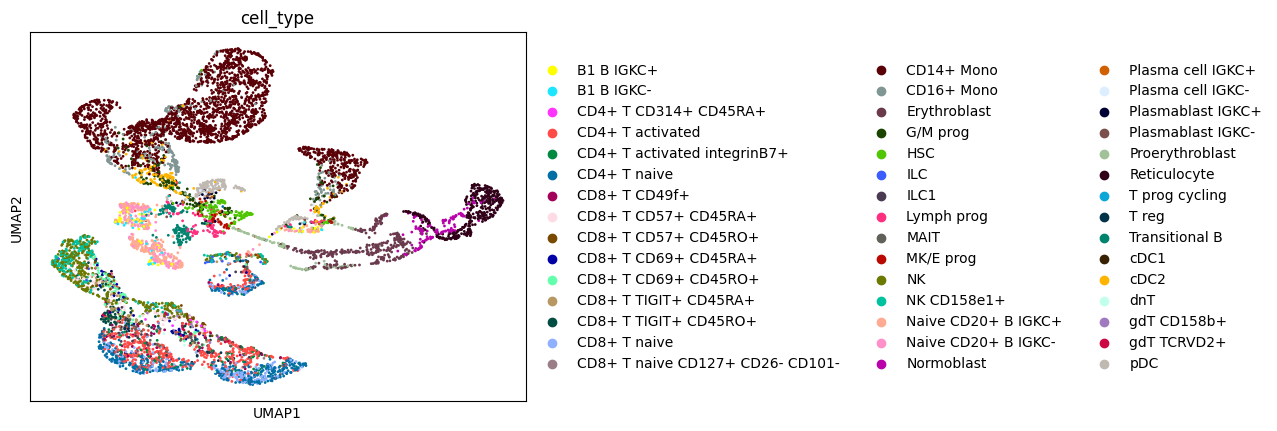

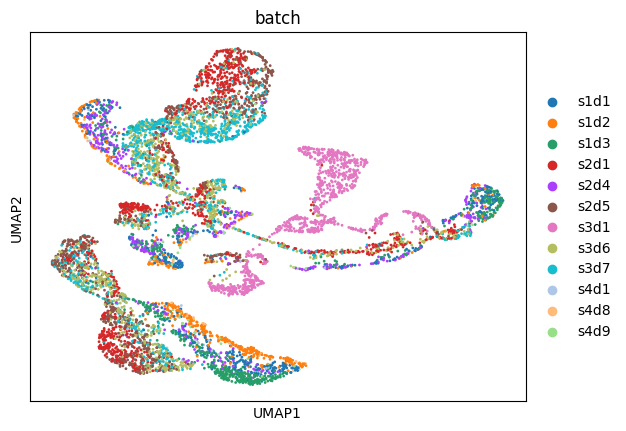

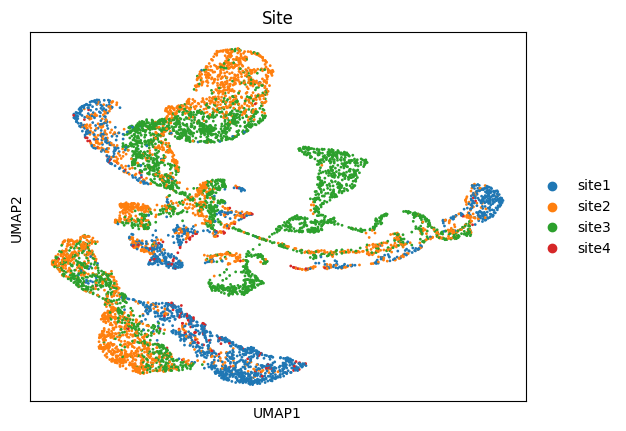

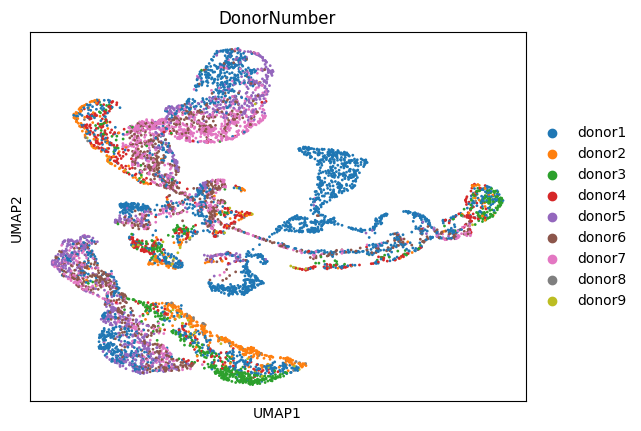

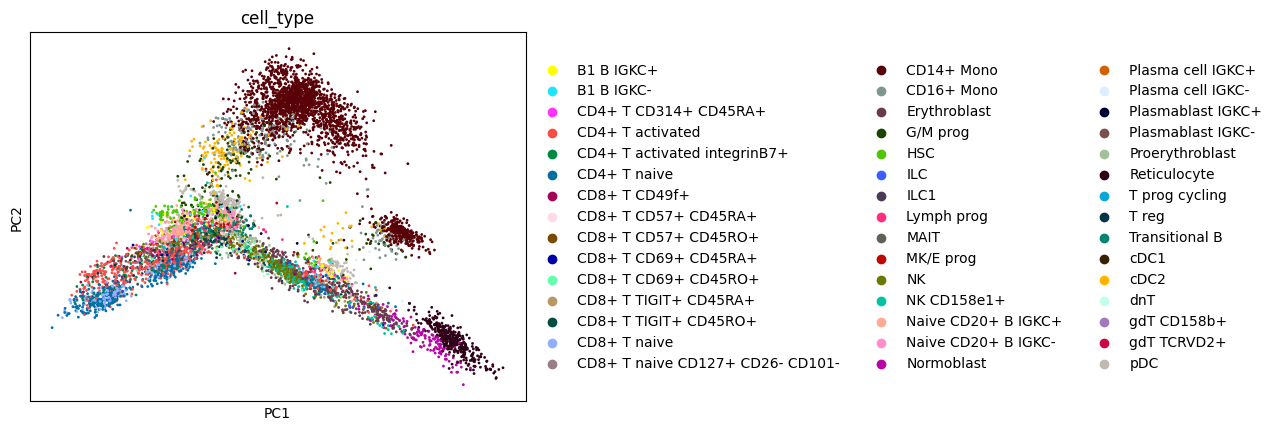

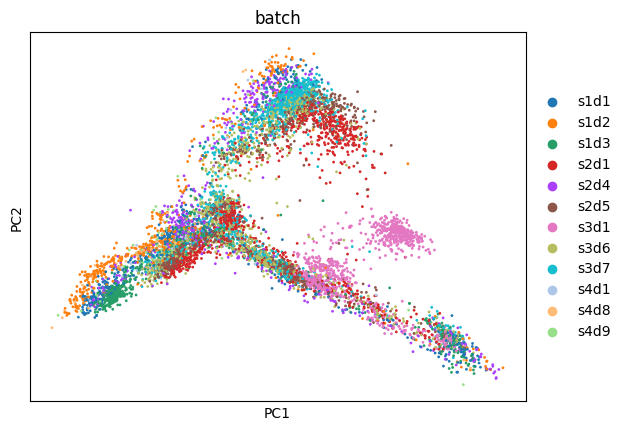

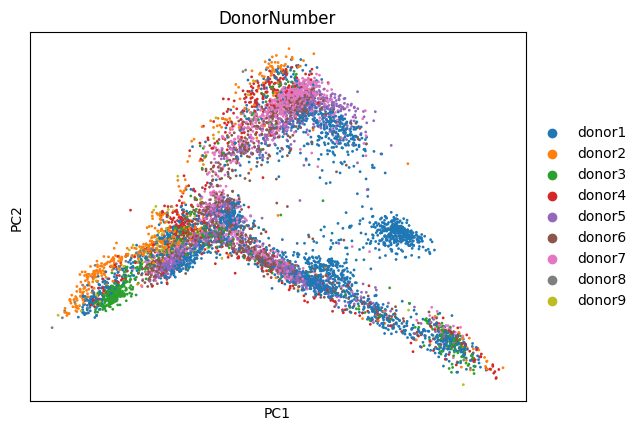

In [114]:
dev.draw_umaps_pca(embeddings, val_df, n_comps=16)

## RAE with latent fuzzy clustering

Latent constraint:

$-\log \sum_p \pi_p \cdot \exp(-d(z, \mu_p)) = -\log \sum_p \exp \log \left( \pi_p \cdot \exp(-d(z, \mu_p)) \right ) = -\log \sum_p \exp \left( \log \pi_p + \log \left(\exp(-d(z, \mu_p)) \right ) \right) = -\log \sum_p \exp \left( \log \pi_p -d(z, \mu_p)  \right) = -\log \text{sum} \exp_p \left( \log \pi_p -d(z, \mu_p)  \right)$

For specific distance metrics it may be treated like log likelihood of some mixture distribution.

Think through the possibility of all logits being driven up - is it encouraged? it does not seem so, but one must analyse the gradient. The gradient is softmax times the gradietn wrt the inside of softmax - the inside of softmax is always negative so all updates of the logits are positive  yajks

This is the same problem like in the policy gradient without bias.

Actually since the logits induced distribution is addition invariant the logits may be positive and if they grow too much they are punished as the logit minus stgh positive may be positive leading to negative gradient update, but the logit must be greater than the distance in the latent.

In [180]:
from torch.nn.utils import spectral_norm


class FCRAE(AE):
    def __init__(self, cfg):
        super(FCRAE, self).__init__(cfg)
        if cfg.model.decoder.spectral_norm.is_applied:
            self._wrap_decoder_weights_with_spectral_norm()
        if cfg.model.decoder.weight_clipping.is_applied:
            self._clip_decoder_weights()

        if cfg.training.losses.latent_regularization.is_applied:
            if cfg.training.losses.latent_regularization.type == "mse":
                self._latent_reg_loss = F.mse_loss
            elif cfg.training.losses.latent_regularization.type == "huber":
                self._latent_reg_loss = F.huber_loss
            else:
                raise NotImplementedError

        self.component_logits = torch.nn.Parameter(
            torch.zeros(cfg.model.latent_constraint.no_components)
        )
        self.component_means = torch.nn.Parameter(
            torch.empty(cfg.model.latent_constraint.no_components, cfg.model.latent_dim)
        )
        torch.nn.init.xavier_normal_(self.component_means)

    def _wrap_decoder_weights_with_spectral_norm(self):
        r"""
        Apply spectral normalization to the decoder layers
        """
        for module in self.decoder.modules():
            if isinstance(
                module, nn.Linear
            ):  # note that it is applied to the linear layers only
                spectral_norm(
                    module,
                    n_power_iterations=self.cfg.model.decoder.spectral_norm.n_power_iterations,
                )  # This is implemented via a hook that calculates spectral norm and rescales weight before every forward() call.

    def _register_decoder_weight_clipping_hook(self):
        r"""
        Register a hook to clip the weights of the decoder
        """

        def _clip_weights_hook(module: nn.Module, input: Tensor) -> None:
            if module.training:
                if hasattr(module, "weight"):
                    with torch.no_grad():
                        module.weight.data._clamp(
                            self.cfg.model.decoder.weight_clipping.min,
                            self.cfg.model.decoder.weight_clipping.max,
                        )

        for module in self.decoder.modules():
            if isinstance(module, nn.Linear):
                module._register_forward_post_hook(_clip_weights_hook)

    def _calc_latent_regularization_loss_term(self, z: Tensor) -> Tensor:
        r"""
        Compute the latent regularization loss.
        """
        return -torch.logsumexp(
            self.component_logits[None, :, None]
            - self._latent_reg_loss(
                z[:, None, :], self.component_means[None, :, :], reduction="none"
            ),
            dim=1,
        ).sum()

    def _calc_recon_loss_term(self, x_hat: Tensor, x: Tensor) -> Tensor:
        r"""
        Compute the reconstruction loss
        """
        return F.mse_loss(x_hat, x)

    def _calc_component_regularisation_loss_term(self) -> Tensor:
        r"""
        Compute the component regularisation loss
        """
        return self.component_means.pow(2).sum()

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

    def training_step(self, batch, batch_idx):
        x = batch[0]
        x_hat, z = self(x)
        recon_loss = self._calc_recon_loss_term(x_hat, x)
        latent_regularization_loss = self._calc_latent_regularization_loss_term(z)
        component_regularisation_loss = self._calc_component_regularisation_loss_term()
        loss = (
            self.cfg.training.losses.recon.weight * recon_loss
            + self.cfg.training.losses.latent_regularization.weight
            * latent_regularization_loss
            + self.cfg.training.losses.latent_regularisation.component_regularisation.weight
            * component_regularisation_loss
        )
        self.log_dict(
            {
                "train_recon_loss": recon_loss,
                "train_latent_regularization_loss": latent_regularization_loss,
                "train_component_regularisation_loss": component_regularisation_loss,
            },
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[0]
        x_hat, z = self(x)
        recon_loss = self._calc_recon_loss_term(x_hat, x)
        latent_regularization_loss = self._calc_latent_regularization_loss_term(z)
        loss = (
            self.cfg.training.losses.recon.weight * recon_loss
            + self.cfg.training.losses.latent_regularization.weight
            * latent_regularization_loss
        )
        self.log_dict(
            {
                "val_recon_loss": recon_loss,
                "val_latent_regularization_loss": latent_regularization_loss,
            },
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )

        return loss

In [181]:
# be flexible about the configuration
cfg_dict = {
    "model": {
        "model_name": "fcrae_1.0",
        "num_genes": 14087,
        "embedding_dim": 50,
        "latent_dim": 20,
        "encoder": {
            "batch_norm": True,
            "dropout": 0.0,
        },
        "decoder": {
            "batch_norm": True,
            "dropout": 0.0,
            "spectral_norm": {
                "is_applied": True,
                "n_power_iterations": 1,
            },
            "weight_clipping": {
                "is_applied": False,
                "min": -1,
                "max": 1,
            },
        },
        "latent_constraint": {"no_components": 20},
    },
    "training": {
        "batch_size": 64,
        "optimizer": {
            "encoder": {
                "type": "AdamW",
                "kwargs": {
                    "lr": 1e-3,
                    "weight_decay": 1e-4,
                    "momentum": 0.9,
                    "nesterov": True,
                    "amsgrad": True,
                },
            },
            "decoder": {
                "type": "AdamW",
                "kwargs": {
                    "lr": 1e-3,
                    "weight_decay": 1e-3,
                    "momentum": 0.9,
                    "nesterov": True,
                    "amsgrad": True,
                },
            },
            "second_phase_gamma": 0.9,
            "scheduler_frequency": 1,
            "first_phase_iters": 5,
        },
        "losses": {
            "recon": {"type": "mse", "weight": 1.0},
            "latent_regularization": {
                "is_applied": True,
                "type": "mse",
                "weight": 0.1,
                "components_regularization": {
                    "is_applied": False,
                    "weight": 0.001,
                },
            },
            "decoder_regularization": {"is_applied": False, "weight": 1.0},
        },
        "n_epochs": 10,
    },
}

fcrae_cfg = dev.dict_to_namespace(cfg_dict)

In [182]:
model = FCRAE(fcrae_cfg)

In [183]:
trainer = pl.Trainer(
    max_epochs=fcrae_cfg.training.n_epochs,
    logger=pl.loggers.TensorBoardLogger(LOGS_PATH, name=fcrae_cfg.model.model_name),
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [184]:
trainer.fit(model, train_loader, val_loader)


  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | encoder      | Encoder | 708 K  | train
1 | decoder      | Decoder | 722 K  | train
  | other params | n/a     | 420    | n/a  
-------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.723     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/prz/bioml/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/tmp/ipykernel_71039/3126164191.py:65: UserWarning: Using a target size (torch.Size([1, 20, 20])) that is different to the input size (torch.Size([64, 1, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  - self._latent_reg_loss(
/home/prz/bioml/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

## Embeddings UMAP - FCRAE

In [ ]:
embeddings_path = dev.get_data_embeddings(
    tensor_dataset=val_tensor_dataset, model=model
)

In [ ]:
with h5py.File(embeddings_path, "r") as h5f:
    embeddings = h5f["embeddings"][:]

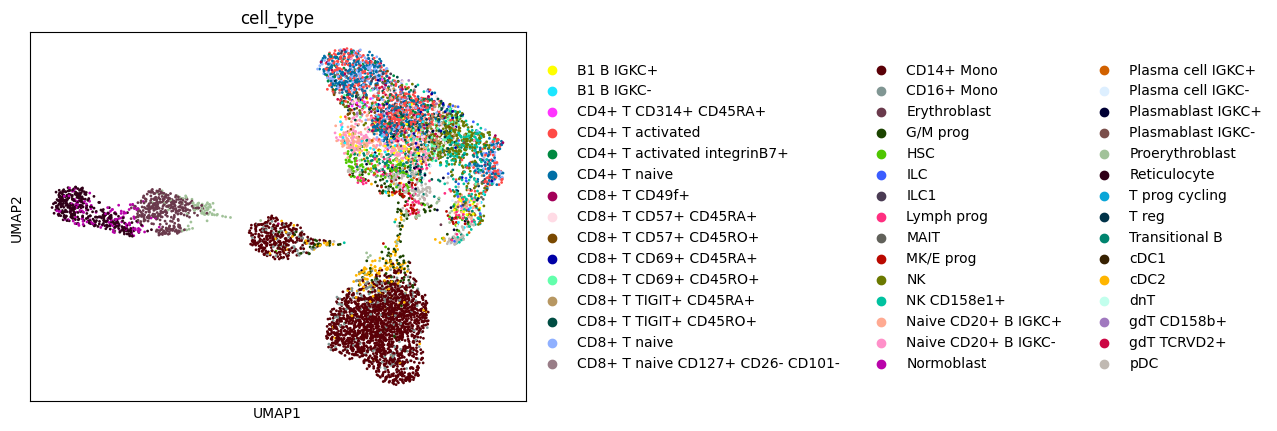

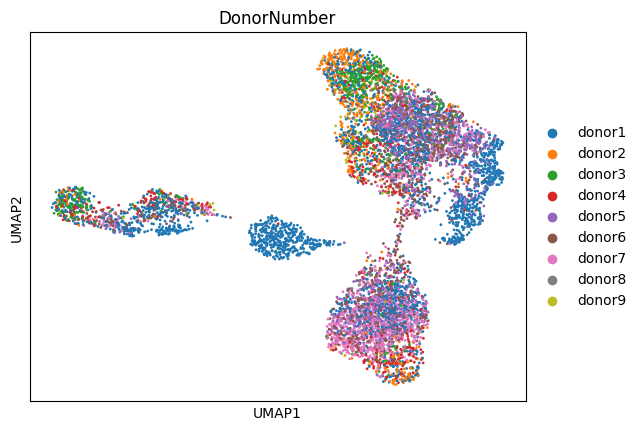

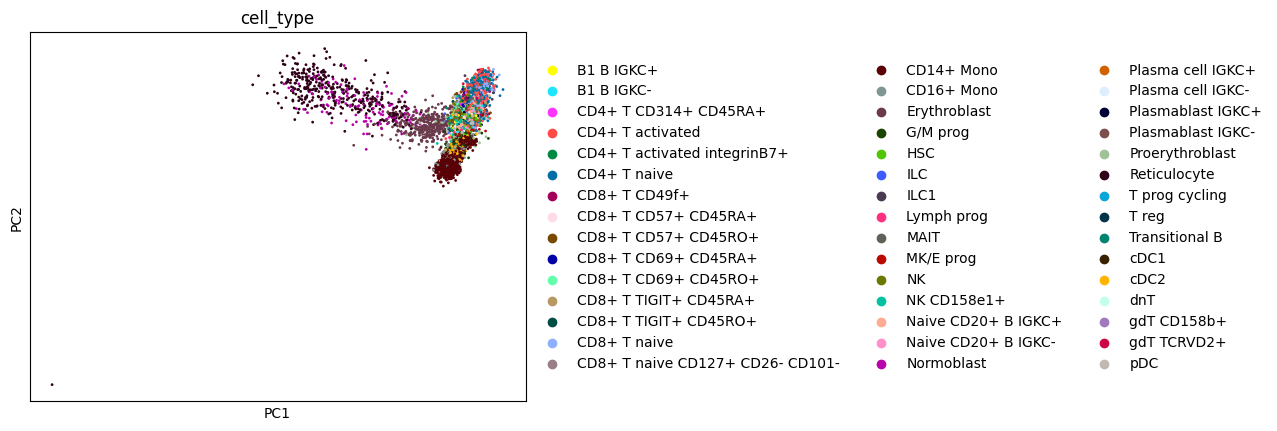

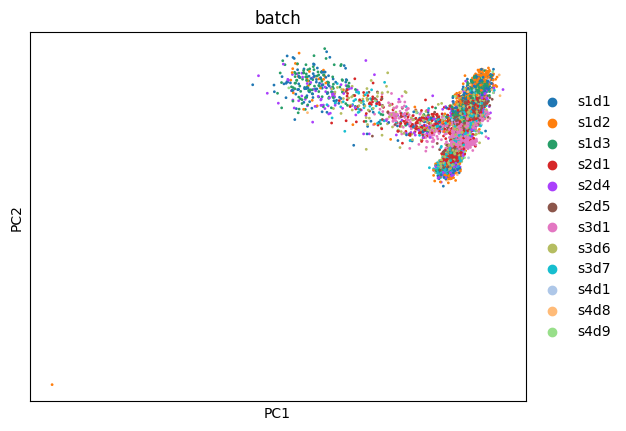

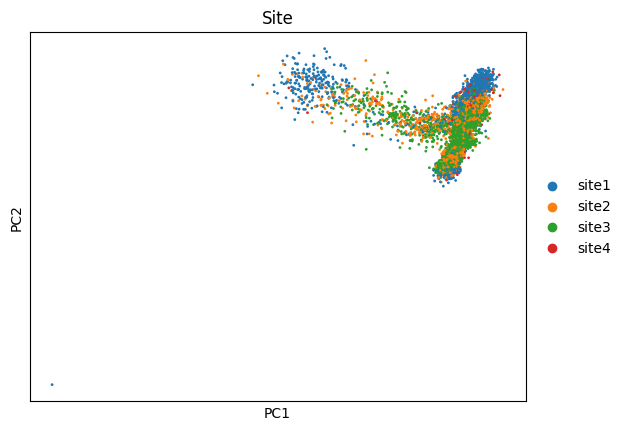

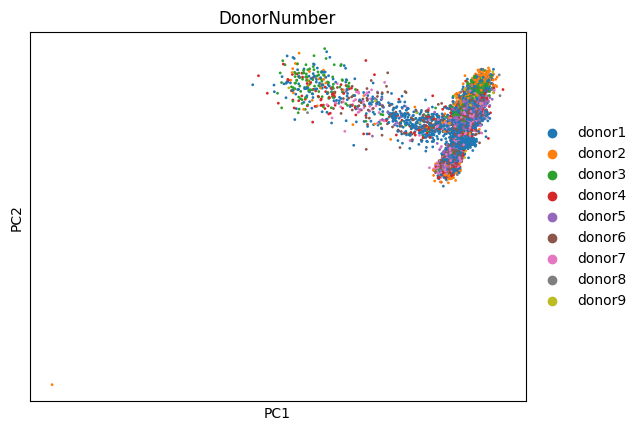

In [ ]:
dev.draw_umaps_pca(embeddings, val_df, n_comps=16)

## Conditioan FCRAE